## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Python Version

In [1]:
from platform import python_version
print(python_version())

3.6.3


## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [27]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
# for plotting heatmap
import seaborn as sns

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [29]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k / n_records * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


### Featureset Exploration
#### Continuous data

In [30]:
for s in data.select_dtypes(exclude='object').columns:
    print(f'- {s}: continuous')

- age: continuous
- education-num: continuous
- capital-gain: continuous
- capital-loss: continuous
- hours-per-week: continuous


#### Categorical data

In [31]:
for s in data.select_dtypes(include='object').columns:
    print(f'- {s}: {data[s].unique()}')
    print()

- workclass: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']

- education_level: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']

- marital-status: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

- occupation: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Transport-moving' ' Farming-fishing'
 ' Machine-op-inspct' ' Tech-support' ' Craft-repair' ' Protective-serv'
 ' Armed-Forces' ' Priv-house-serv']

- relationship: [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

- race: [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

- sex: [' Male' ' Female']

- native-country: [' United-States' ' Cuba' ' Jamaica'

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

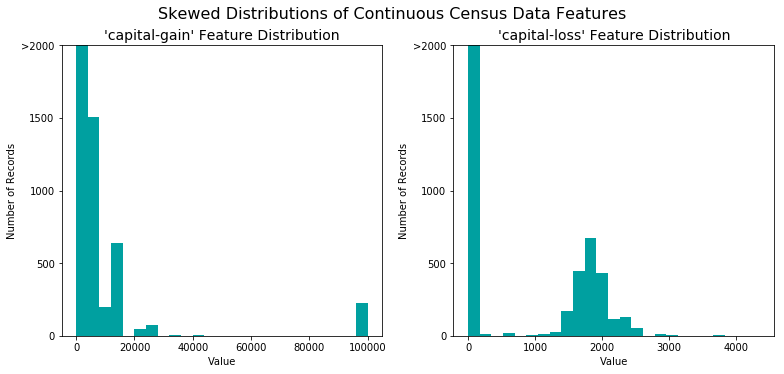

In [32]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

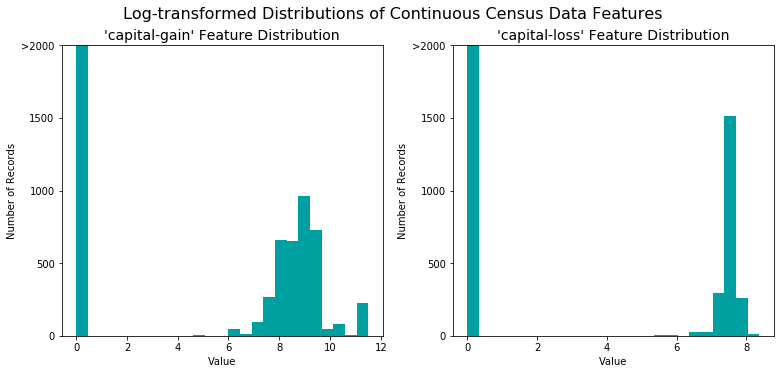

In [33]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Additional observations
#### High proportion of `0's` in `capital-gain` and `capital-loss`
- We observe a high proportion of 0s in the two columns above

#### Moderate correlation between numerical columns and y value
- There seems to be decent correlation, i.e. `education-num`, `capital-gain` and `age` against income > 50k
- This would suggest a linear classification algorithm (Logistic Regression, linear SVMs) may benefit from this

In [34]:
capital_gain_bool = features_log_transformed['capital-gain'] == 0.00
capital_loss_bool = features_log_transformed['capital-loss'] == 0.00
print(f"0s in capital-gain: {round(sum(capital_gain_bool) / n_records * 100, 2)}%")
print(f"0s in capital-loss: {round(sum(capital_loss_bool) / n_records * 100, 2)}%")

0s in capital-gain: 91.62%
0s in capital-loss: 95.27%


In [36]:
numeric_corr = features_log_transformed[list(features_log_transformed.select_dtypes(exclude='object').columns)].copy()
numeric_corr['income'] = data['income'].map({'>50K': 1, '<=50K':0})
corr = numeric_corr.corr()
corr['income']

age               0.237040
education-num     0.332800
capital-gain      0.287740
capital-loss      0.139253
hours-per-week    0.227199
income            1.000000
Name: income, dtype: float64

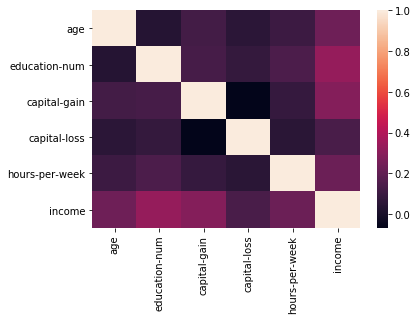

In [37]:
# Correlation heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [38]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [39]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
# Only converts categorical variables - https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = data['income'].map({'>50K': 1, '<=50K':0})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [40]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000,  and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [41]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# variables - n_records, n_greater_50k, n_at_most_50k

# TODO: Calculate accuracy, precision and recall
accuracy = np.sum(income) / income.count()
recall = np.sum(income) / np.sum(income) # no true negatives
precision = np.sum(income) / income.count() # Total predicted positives = count of all data

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5 ** 2) * (precision * recall / (0.5 ** 2 * precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


In [42]:
# Proving from metric functions
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
y_true = income == 1
y_pred = pd.Series([1 for x in range(income.count())])
acc = accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
f = fbeta_score(y_true, y_pred, 0.5)
print("Cross checking against sklearn functions: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(acc, f))

Cross checking against sklearn functions: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

## Considerations over model selection
### 1. Problem at hand
- As we are trying to predict whether an individual (i) earns more than 50k or (ii) earns 50k or less, we are trying to solve a **Classification Problem**, hence Linear Regression would not be a suitable model 

### 2. Speed or accuracy
**Speed**
- **Fastest**: Naive Bayes and Logistic Regression are very fast to train as their implementation are relatively simple
- **Fast**: Decision Trees are slightly slower than the two above, but the time loss would not be significant
- **Moderate**: Ensemble algorithms, e.g. RandomForest, Adaptive Boosting (AdaBoost), GradientBoosting will be slower to train that above due to the need to train and create alot of weak learners.
- **Slow**: Support Vector Machines (SVM) take the most time to train due to being very memory intensive, especially if our dataset is large

**Hyperparameter tuning**
- Faster trained models tend to be **simpler** since they have less hyperparameters to be tuned

**Accuracy**
- Generally, speed of model training comes at a cost of accuracy. E.g. Ensemble methods would generally perform well compared to Regression models, Naive Bayes or the simpler Decision Tree as long as the hyperparameters are tuned well.
- However, logistic regression tends to still perform really well
- Although SVMs take a considerable amount of time to train and ensemble methods still generally perform better than them. SVMs are good if the dataset is relatively small

**Interpretability**
- Higher accuracy models tend to me more complex, and this may come at the cost of interpretability.
- More complex models difficult to assess its performance relative to the parameters inputted
- If the objective is to have an easier understood model, **restrictive models** (i.e. high bias) are preferred over more **flexible models** (i.e. low bias)

### 3. Data
**Size of dataset**
- Many of times, availability of data is a constraint
- If data is **small**, or has higher features compared to observations (e.g. genetics/ textual data), **high bias/ low variance** algorithms are preferred:
    - e.g. [Logistic regression](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/), Naive Bayes, Linear SVMs
- If data is **large**, or has higher observations vs features, **low bias/ high variance** methods are preferred:
    - e.g. KNN, Decision Trees, Kernel SVMs

**Linearity of data**
- Linear data where variable/data trends follow a straight line
    - e.g. Logistic Regression/ Linear SVMs tend to perform well
    - 1 method to check for linearity is to fit a line and check for residual errors from the algorithm
- Non-linear data, hence need algorithms that handle high dimensionals and complex data structures
    - e.g. Ensemble methods, kernel SVMs

**High number of features**
- large number of features can bog down some learning algorithms, making training time unfeasibly long
- SVM is better suited in case of data with large feature space and lesser observations. 
- Principal Component Analysis (PCA) and feature selection techniques should be used to reduce dimensionality and select important features.

### References
- [Guide in choosing right machine learning algorithm - kdnuggets](https://www.kdnuggets.com/2020/05/guide-choose-right-machine-learning-algorithm.html)
- [Strengths and weaknesses in ML algorithms](https://www.kaggle.com/getting-started/174963)

## What models `not to use`
#### Naive Bayes
- The two main Naive Bayes models are Multinomial and Gaussian Naive Bayes. Gaussian Naive Bayes utilises the gaussian (normal) distribution to classify our data. And it assumes that our feature(s) are continuous, and hence would work great if there are alot of features and majority of them are continuous.
- However since majority of our data are binary, e.g. `workclass`, `education_level`, `marital-status`, `occupation`, `relationship`, `race`, `sex`. This algorithm would **not produce optimum results** *(as we will observe below)*.

<ins>References</ins>
- [When to use naive bayes](https://www.quora.com/On-what-type-of-data-sets-we-should-use-Naive-Bayes-and-when-to-use-Gaussian-naive-Bayes-in-Machine-Learning)
- [Datasets to use Naive Bayes](https://www.quora.com/On-what-type-of-data-sets-we-should-use-Naive-Bayes-and-when-to-use-Gaussian-naive-Bayes-in-Machine-Learning)

#### Decision Trees
- They are simple, but tend to overfit
- Easily beaten by ensemble methods which also utilises decision trees as a weak learner

#### Support Vector Machines (SVMs)
- Considering the size of our dataset, i.e. 45k, SVMs will take a considerable amount of time to train our data
- Ensemble methods generally are on par and even outperform SVMs, with significantly lesser time training the data
- SVMs are good if the number of data observations are less, and that its feature size is huge, e.g. genetic data or text data.
- Considering its long training time, hyperparameter tuning would be exponentially longer.

#### K Nearest Neighbors (KNN)
- Similarly as SVMs, KNN take a long time to train since it the model stores all data points
- Using KNN requires us to tweak the K value to ensure it doesn't over or underfit. Considering the size of our dataset, it will take a considerable amount of time to tweak its hyperparameters.

## `3 Models to consider`
Describe one real-world application in industry where the model can be applied.
What are the strengths of the model; when does it perform well?
What are the weaknesses of the model; when does it perform poorly?
What makes this model a good candidate for the problem, given what you know about the data?

#### 1. Logistic Regression
<ins>Real world application</ins>
- Logistic regression is beneficial for instances where there is high-dimensionality in the data, i.e. high number of features
- real world applications include, Natural Language Processing (NLP), and identification of diseases in genetics, both of which present high features in its data

<ins>Strengths</ins>
- It can be trained very fast. So it is appropriate when training time is a limiting factor
- It is easily understood and explanable, since it can easily be represented by a sigmoid curve
    - Especially for business instances where the model is under regulatory scrutiny

<ins>Weaknesses</ins>
- A major weakness is that it assumes linearity between variables
- It does very poorly for datasets where there is no linearlity between features

<ins>Problem at hand</ins>
- From inspection of the correlation heat map between numerical features above, there seems to be a decent level of correlation where linear regression can benefit from.
- Since we have a larger dataset of 45k, linear regression is likely to [benefit from it more](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-logistic-regression/) 

<ins>References</ins>
- [When logistic regression is better than regression](https://www.quora.com/When-is-using-logistic-regression-better-than-ensembles)
- [Advantages and disadvantages](https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/)
- [Logistic Regression for high-dimensionality problems](https://www.quora.com/What-are-the-advantages-of-logistic-regression-over-decision-trees-Are-there-any-cases-where-its-better-to-use-logistic-regression-instead-of-decision-trees)

#### 2. Adaptive Boosting (AdaBoost)

<ins>Real world application</ins>
- [Customer churn predictions](https://www.cs.rit.edu/~rlaz/PatternRecognition/slides/churn_adaboost.pdf)
- [Financial portfolio management](https://www.worldscientific.com/doi/abs/10.1142/S2424786321420019)

<ins>Strength</ins>
- It's hyperparamters are easy to tune given that it only a few considerable ones, i.e. `n_estimators` and `learning_rate`
    - So easy to have a sense over which weak learner is to blame
- It performs generally well

<ins>Weaknesses</ins>
- High quality data is required as AdaBoost is sensitive to noisy data and outliers given the fact that it tends to give higher weightage to misclassified points. Thus influencing subseqeunt iterations of learning by weak nearlers.
    - However this can be mitigated if we remove outliers during our data exploration and data preprocessing 
    - AdaBoost is also not optimised, so it will be slower than other ensemble algorithms, e.g. RandomForest/XGBoost

<ins>Problem at hand</ins>
- Given the large size of our observations, the lower number of hyperparameters makes AdaBoost easily experimentable

<ins>References</ins>
- [AdaBoost](https://iq.opengenus.org/adaboost/)
- [Types of Booosting algorithms](https://iq.opengenus.org/types-of-boosting-algorithms/)
- [AdaBoost easy guide](https://www.jigsawacademy.com/blogs/data-science/adaboost/)


#### 3. Random Forest
<ins>Real world application</ins>
- Financial sector - fraud detection of loyal and fraudulent customers, e.g. credit card fraud
- Estimating profit/loss for stock purchasing

<ins>Strength</ins>
- Works well if dataset has categorical or numerical data, with no further scaling or transformation of variables necessary
- Handle linear and non-linear relationships well
- Good for high dimensionality datasets, i.e. alot of features due to random forests implicitly performing feature selection in deriving its weak learners
- No significant hyperparameter tuning required to derive good results
- Provides good bias-variance trade off
- Still maintains accuracy when large proportion of data are missing

<ins>Weaknesses</ins>
- Not as good for regression problems compared to classification problems
    - For regression problems, it doesn't predict beyong range in training data
- Random forest is like a black block approach, where we usually have little control over what the model does

<ins>Problem at hand</ins>
- As our dataset is large, model tuning will then take a long time. However, the default parameters for random forest is usually sufficient enough for us to have a good gauge of the final tuned performance of the model. It will quicken our model selection process.
- Our dataset has a mix of categorical and numerical data, of which random forest does well

<ins>References</ins>
- [Towards data science - random forest pros and cons](https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04)
- [Quora random forest pros and cons](https://www.quora.com/What-are-the-advantages-and-disadvantages-for-a-random-forest-algorithm)
- [Kaggle - random forest](https://www.kaggle.com/general/208443)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [43]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(model, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = model.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train[:sample_size], y_train[:sample_size])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(predictions_train, y_train[:sample_size], beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = accuracy_score(predictions_test, y_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [44]:
def compare_models(model1, model2, model3):
    # TODO: Initialize the three models
    clf_A = model1
    clf_B = model2
    clf_C = model3
    # TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
    # HINT: samples_100 is the entire training set i.e. len(y_train)
    # HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
    # HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
    samples_100 = X_train.shape[0]
    samples_10 = samples_100 // 10
    samples_1 = samples_100 // 100

    # Collect results on the learners
    results = {}
    for clf in [clf_A, clf_B, clf_C]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_10, samples_100]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)

    # Run metrics visualization for the three supervised learning models chosen
    vs.evaluate(results, accuracy, fscore)

In [45]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Model comparison

### 1. Gaussian NB, Multinomial NB and Decision Tree Classifier
- 3 of which are very quick learners, with Decision Tree requiring the longest to train
- As expected, results for `Gaussian NB` is pretty bad since our data consists a number of categorical variables, and Gaussian NB is effective for datasets with continous features
- Accuracy for `Multinomial NB` and `Decision Tree` is decent, but other models perform way better.

- **None of these Classifiers will be chosen**

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
MultinomialNB trained on 361 samples.
MultinomialNB trained on 3617 samples.
MultinomialNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


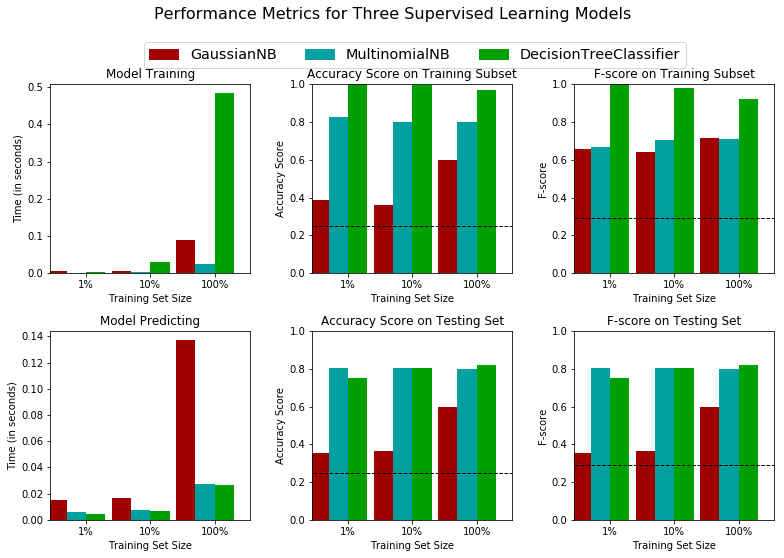

In [22]:
compare_models(GaussianNB(), MultinomialNB(), DecisionTreeClassifier())

### 2. K Nearest Neighbors (KNN), SGD Classifier and Logistic Regression
- `KNN` takes a considerable amount of time to train, time for hyperparameter tuning using GridSearch will be exponential
    - KNN does really well even with very little data compared to the other 2 models
- Both `SGDClassifier` and `LogisticRegression` are linear models
    - SGDClassifier generally underperforms LogisticRegression
- **Logistic Regression is considered since it performs better than SGD and traning time is much less than KNN**

KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


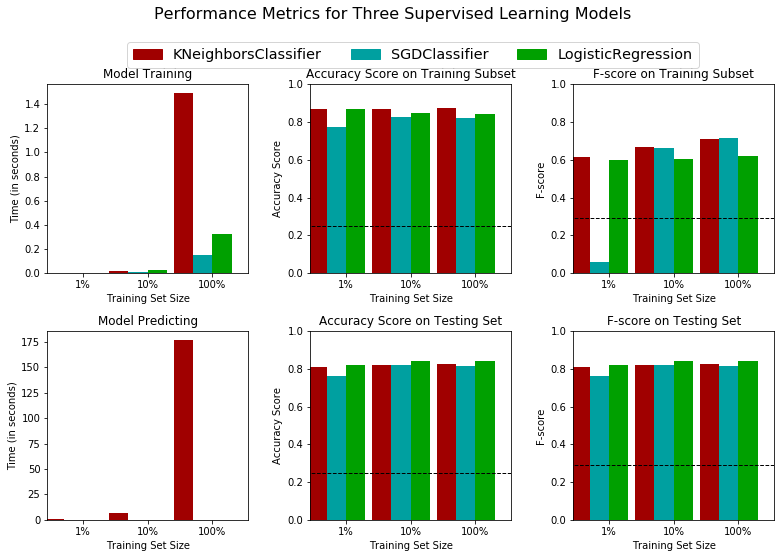

In [23]:
compare_models(KNeighborsClassifier(), SGDClassifier(), LogisticRegression())

### 3. Linear Support Vector Machine (SVM), AdaBoost and GradientBoost
- We will focus mainly on comparison between SVM and ensembles (adaboost and gradientboost), subsequent comparisons between ensemble methods will be performed later
- `SVMs` take a significant amount of time to train as expected due to the size of our dataset.
- Despite this, it still underperforms our ensemble methods both in accuracy and f-score
- **Hence, SVMs will not be considered**

SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


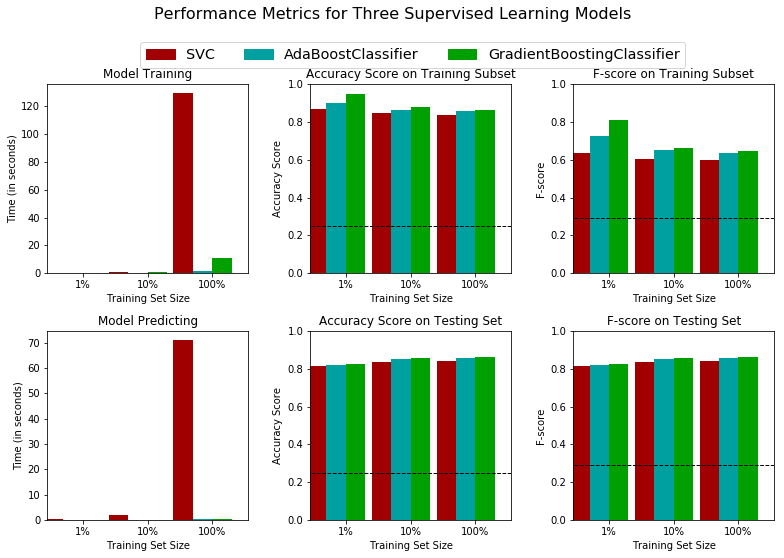

In [53]:
compare_models(SVC(kernel='linear'), AdaBoostClassifier(), GradientBoostingClassifier())

### 4. Random Forest, AdaBoost and GradientBoost
- `GradientBoosting` takes most time to train while `AdaBoost` takes longest time to predict
- `RandomForest` shows to be more flexible in shaping to our training data, given that it has extremely high accuracy and f-scores against our training data.
    - However, it is the weakest among all 3 ensemble methods
- **Considering the significant amount of time required to train using GradientBoosting (5 folds of adaboost), and considering the size of our dataet, `RandomForest` and `AdaBoost` will be used**

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


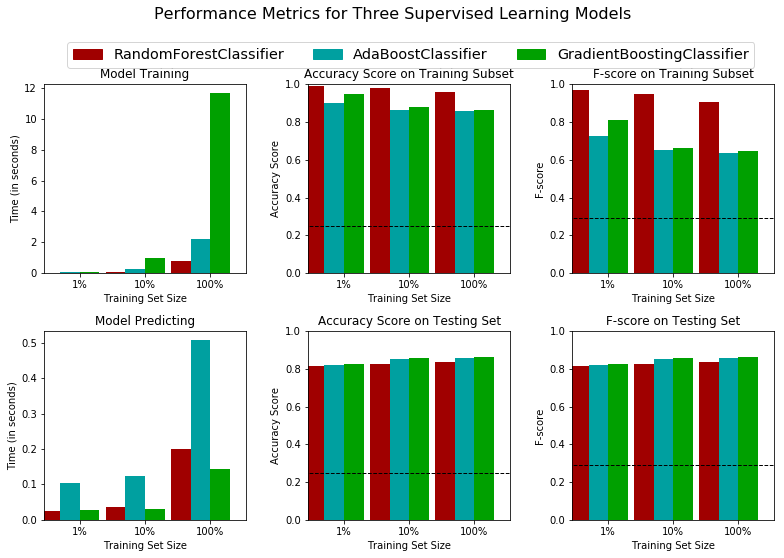

In [68]:
compare_models(RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier())

### 5. FINAL - LogisticRegression, RandomForest and AdaBoost
- All 3 models perform very well in **testing** accuracy and f-score, with LogisticRegression being on par with RandomForest and AdaBoost being the best performing of all
- As expected RandomForest is very flexible, so it has high **training** scores
- Model Training and Model Prediction times follows from
    1. Logistic Regression
    2. Random Forest
    3. AdaBoost

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


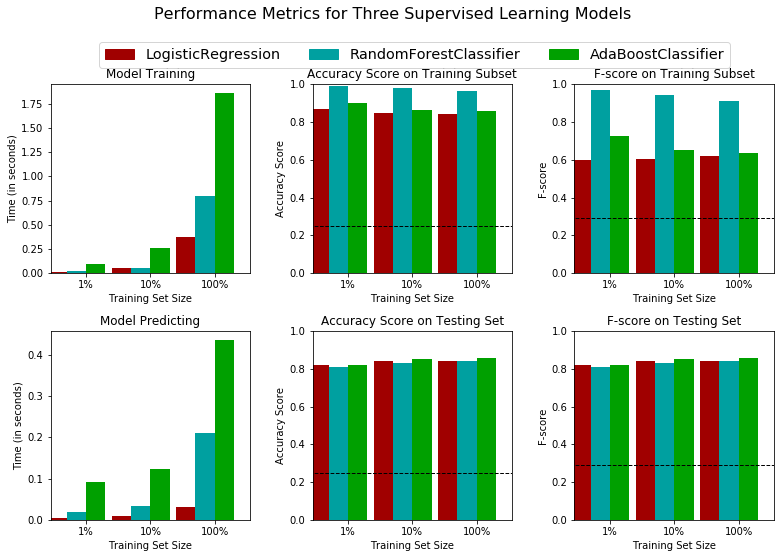

In [70]:
compare_models(LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier())

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:**

Based on my comparison of `LogisticRegression`, `RandomForest` and `AdaBoost` above:

<ins>Metrics</ins>
- AdaBoost has the best accuracy and f1 score among all 3, prior to hypertuning
- Subsequent to hypertuning, I would expect AdaBoost to ourperform the others further, considering that RandomForest's default hyperparameters are sufficient enough to gauge its final performance.
- As our f1 score has a beta of 0.5, it is weighted to precision and evaluation against false positives, AdaBoost performs best for this metric

<ins>Prediction/training time</ins>
- Although it has the highest prediction/training time among all 3, it can compensate its overall hyperparameter tuning time by its relatively low number of hyperparameters (as compared to RandomForst which has numerous)
- Relative to more computationally or memory intensive classifiers, e.g. K Nearest Neighbors, SVMs, or even GradientBoosting, AdaBoost still trains faster than them.

<ins>Suitability for data</ins>
- Due to personal time constraints in conjunction with **size of dataset**, AdaBoost would be appropriate given the few number of hyperparameters required for tuning

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer:**
### **How it is trained**
- `AdaBoost` is an **ensemble** model, this means that it is derived from a collection of weaker models. The final model is a <ins<strong learner</ins>. Weaker models (e.g. Decision Trees) tend to perform poor on actual data (high variance), and ensemble methods addresess this by aggregating weaker learners.
- AdaBoost creates its weaker models one by one. The first weak model created will be assessed and assigned a score of its performance, say it has misclassified 3 data points. These 3 data points will be fed into the 2nd weak model, so that it prioritises the 3 misclassified points. This process repeats until a set number of weak learners are traind. This is a core concept of AdaBoost, i.e. **boosting**, where errors in previous iterations of weak learners are taken into account.

### How prediction is made
- Each of the weak learner mentioned previously will be assigned a score, i.e. the *Amount of say* it has or deserves, e.g.:
    - If a weak learner misclassifies 80% of data, it has a **low** score, or low amount of say
    - If a weak learner correctly classifies 90% of data, it has a **high** score, or high amount of say
- When we make a prediction, we feed our source data into the model. For a classification problem, AdaBoost buckets our weak learners into **making correct** or **making incorrect** predictions.
- The *amount of say score* are added up in both buckets, we compare the total score in both buckets and choose the higher
- e.g. if the aggregated score of the **correct** bucket is 3.56 while **incorrect** is 1.22, we classify the data as **correct**

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

def searchHyperParam(model, parameters):
    # TODO: Initialize the classifier
    clf = model()

    # TODO: Make an fbeta_score scoring object using make_scorer()
    scorer = make_scorer(fbeta_score, beta=0.5)

    # TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
    grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, scoring=scorer, n_jobs=-1)

    # TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = pd.Series(best_clf.predict(X_test))
    
    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print(best_clf)
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])))

### Tuning AdaBoost
- As tuning a grid of parameters would take a considerable amount of time, I perform the following:
    1. Tune learning rate with a low range of n_estimators
    2. Tune with a high range of n_estimators
    3. Tune with a higher range of n_estimators
    4. Tune learning rate with n_estimators of 1000
    5. Tune with algorithm
    6. Tune with difference base_estimators

#### 1. Tune learning rate with a low range of n_estimators
- `n_estimators` of 300 is ideal, and `learning_rate` of 1 is ideal

In [52]:
# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
ada_param1 = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1, 1, 10]
}
searchHyperParam(AdaBoostClassifier, ada_param1)

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=300, random_state=None)
Final accuracy score on the testing data: 0.8663
Final F-score on the testing data: 0.7425
Final ROC-AUC on the testing data: 0.9243


#### 2. Tune with a high range of n_estimators
- n_estimators of `1000` is ideal

In [50]:
ada_param2 = {
    'n_estimators': list(range(100, 1300, 300)),
}
searchHyperParam(AdaBoostClassifier, ada_param2)

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448
Final ROC-AUC on the testing data: 0.9268


#### 3. Tune with a higher range of n_estimators
- n_estimators of `1000` is still ideal

In [51]:
ada_param3 = {
    'n_estimators': list(range(1000, 4100, 1000)),
}
searchHyperParam(AdaBoostClassifier, ada_param3)

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448
Final ROC-AUC on the testing data: 0.9268


#### 4. Tune `learning rate` with n_estimators of 1000
- similarly as above, `learning_rate` of 1 is ideal

In [53]:
ada_param4 = {
    'learning_rate': [0.01, 0.1, 1, 10],
    'n_estimators': [1000]
}
searchHyperParam(AdaBoostClassifier, ada_param4)

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=1000, random_state=None)
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448
Final ROC-AUC on the testing data: 0.9268


#### 5. Tune with algorithm
- default `SAMME.R` is ideal

In [54]:
ada_param5 = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators':[1000]
}
searchHyperParam(AdaBoostClassifier, ada_param5)

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448
Final ROC-AUC on the testing data: 0.9268


#### 6. Tune with difference base_estimators
- default `DecisionTreeClassifier`, i.e. `None` is preferred
- [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [55]:
ada_param6 = {
    'base_estimator': [LogisticRegression, DecisionTreeClassifier, SGDClassifier],
    'n_estimators':[1000]
}
searchHyperParam(AdaBoostClassifier, ada_param5)

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448
Final ROC-AUC on the testing data: 0.9268


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

In [69]:
best_clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)
best_predictions = best_clf.fit(X_train, y_train).predict(X_test)

#### Results:

|     Metric     | Unoptimized Model | Optimized Model | Naive Predictor |
| :------------: | :---------------: | :-------------: | :-------------: | 
| Accuracy Score |     0.8576        |   0.8676        |   0.2478        |
| F-score        |     0.7246        |   0.7448        |   0.2917        |


- My final optimised model are as follows:

        AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                  learning_rate=1.0, n_estimators=1000, random_state=None)
                  
- My optimised model offered a 1% increase in accuracy and 0.02 increase in F-score
- It outperformed our naive predictor by 62% in accuracy and 0.45 in F-score

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

In [74]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

Ranking for most important to least based on **perceived** direct relation with `Income`
1. **occupation** - Very correlated to income since individuals with higher income tend to cluster in the same groupings
2. **age** - Younger people tend to mean less seniority. Higher management positions in comparies tend to be geared to individuals with higher seniority.
3. **education_level** / education-num - Higher education generally relates to more prestegrious or well paying roles in organisations
4. **workclass** - Individuals employed in private enterprises tend be paid higherer than local or state government jobs
5. **hours-per-week** - Higher hours-per-week would generally would result in higher income

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

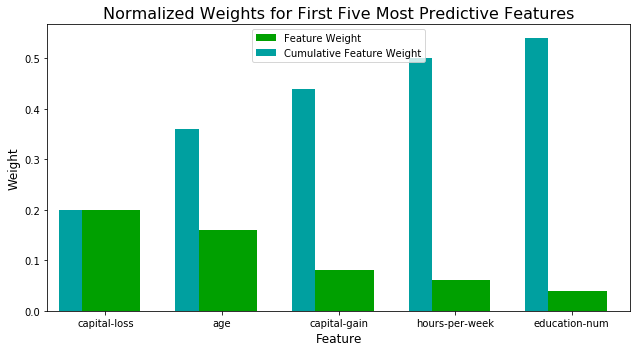

In [82]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

Having guessed 3 out of 5 of the most predictive features, as compared `AdaBoost`, it:
1. Gave more emphasis over `age` and `hours-per-week`
2. Gave less emphasis over `education-num`
3. Also gave emphasis to `capital-gain` and `capital-loss`

<ins>Similarities</ins>

My initial guesses were based on a mix of **gut feeling of direct relation** and **emphasis over continuous features**. It seems that `AdaBoost` also mostly emphasises continuous features as well since 5 out of 5 of the top 5 important features are continuous.

<ins>Future Considerations</ins>

It may be beneficial to deconstruct categorical features further rather than considering importance of the feature as a whole. Although our `AdaBoost` doesn't place a top 5 importance to them, `RandomForest` does place an importance to `Married-civ-spouse`

E.g. considering `Married-civ-spouse`, married with spouse by itself rather than the `maritial-status` feature as a whole. If we use One-hot-encoding, our models view categorical features as expanded tables of `1`s and `0`s, so we need to consider one-hot encoded features separately too.

There are other choices of encoding, e.g. `Ordinal encoding` where we assign a sequence of integers to a single categorical. But this still requires us to reframe our perspective over how models view data.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [83]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8676
F-score on testing data: 0.7448

Final Model trained on reduced data
------
Accuracy on testing data: 0.8433
F-score on testing data: 0.7053


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

<ins>Comparison of F-score and accuracy-score</ins>
- Our model with reduced data performed slightly worse in both accuracy (decrease of 2%) and f-score (0.04)

<ins>Consideration of using reduced data as training set</ins>
- It may be beneficial to perform a **wider** hyperparameter tuning using a reduced dataset, and then revisit the entire full dataset once we have a good gauge over a **narrower** range of hyperparamters to use, since AdaBoost still takes a considerable amount of time to train.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [1]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 795043 bytes to finding_donors.html']

In [2]:
!zip -r finding_donors.zip *

updating: README.md (deflated 47%)
updating: __pycache__/ (stored 0%)
updating: __pycache__/visuals.cpython-36.pyc (deflated 47%)
updating: census.csv (deflated 93%)
updating: finding_donors.html (deflated 57%)
updating: finding_donors.ipynb (deflated 37%)
updating: project_description.md (deflated 57%)
updating: visuals.py (deflated 66%)
